## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import itertools
from datetime import datetime
from copy import copy, deepcopy

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.exceptions import DataConversionWarning
# import xgboost as xgb

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor

# Disabling warnings
import warnings
warnings.filterwarnings('ignore')

rs = 85

import scienceplots
plt.style.use(['ieee', 'notebook'])
plt.style.use(['seaborn-v0_8-whitegrid'])
# plt.style.use(['seaborn-whitegrid'])

## Importando os dados

Recovering from picke, comment if not necessary

In [3]:
# prefix = 'DECV2.MISO.W1_L'
# binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
# print(binary)

# with open(binary, 'rb') as bin_file:
#     X1_tr, y_tr, X1_te, y_te, results_dict, df, df2 = pickle.load(bin_file)


### Lendo dados

In [4]:
os.getcwd()

'c:\\Users\\bewm\\OneDrive - PETROBRAS\\Documents\\2_Projetos\\Mestrado\\SYSID_Trabalho\\Volve-Dataset'

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    # data = pickle.load(bin_file)
    data = pd.compat.pickle_compat.load(bin_file)


c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\Mestrado\SYSID_Trabalho\Volve-Dataset\data\volve_compiled.pkl


In [3]:
for wellp in data['OP'].keys():
    print(wellp)


15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


# Selecionando dados

In [4]:
# case = "15/9-F-14"
case = "15/9-F-1 C"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]


# Plotando dados

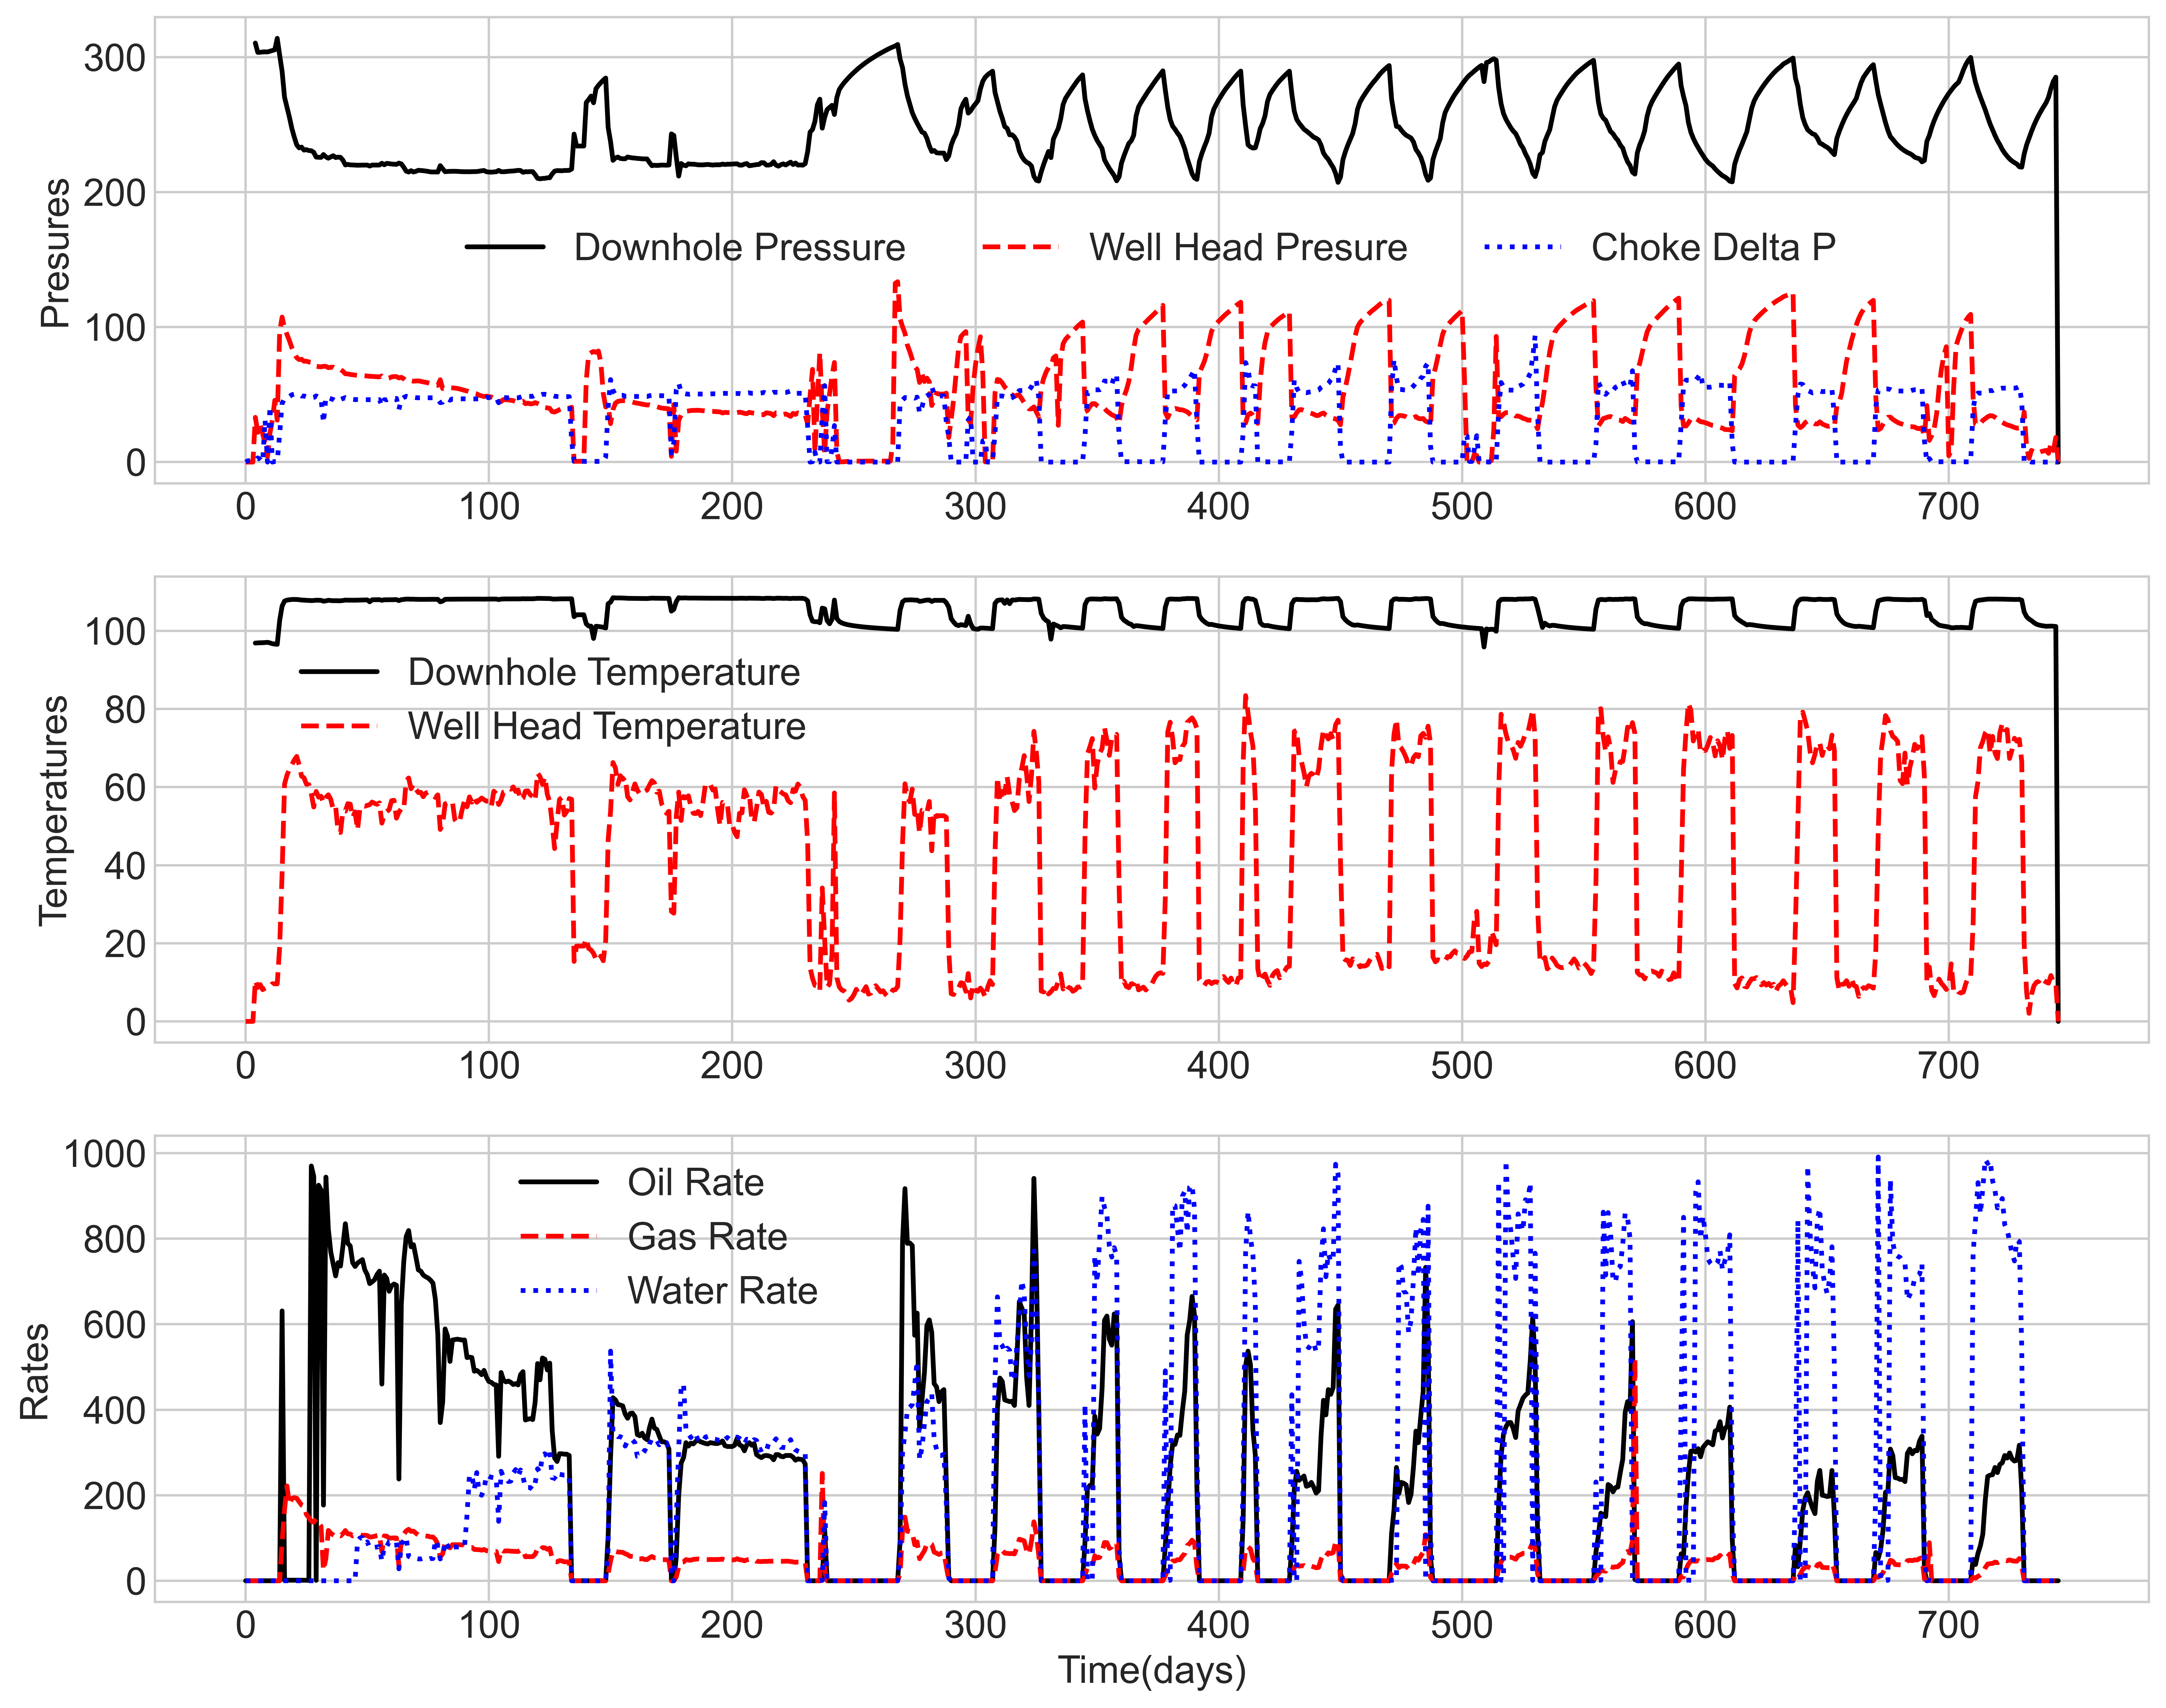

In [5]:
time = data_case['N']

plot_dict_P = {
'AVG_DOWNHOLE_PRESSURE':'Downhole Pressure',
'AVG_WHP_P':'Well Head Presure',
# 'AVG_DP_TUBING':'Tubing Delta P',
# 'AVG_ANNULUS_PRESS':'Annulus Pressure',
'AVG_CHOKE_SIZE_P':'Choke Delta P',
# 'DP_CHOKE_SIZE':'DP_CHOKE_SIZE_P',
}
plot_dict_T = {
'AVG_DOWNHOLE_TEMPERATURE':'Downhole Temperature',
'AVG_WHT_P':'Well Head Temperature',
}
plot_dict_Q = {
'BORE_OIL_VOL':'Oil Rate',
'BORE_GAS_VOL':'Gas Rate',
'BORE_WAT_VOL':'Water Rate',
}

fig, ax = plt.subplots(3,1, figsize=(15,12))

for k,v in plot_dict_P.items():
    ax[0].plot(time, data_case[k], label=v)

for k,v in plot_dict_T.items():
    ax[1].plot(time, data_case[k], label=v)

for k,v in plot_dict_Q.items():
    ax[2].plot(time, data_case[k], label=v)

ax[0].legend(ncol=3)
ax[0].set_ylabel('Presures')

ax[1].legend(bbox_to_anchor=(0.2,0.9))
ax[1].set_ylabel('Temperatures')

ax[2].legend(bbox_to_anchor=(0.35,0.55))
ax[2].set_ylabel('Rates')
ax[2].set_xlabel('Time(days)')

# p = os.path.join(os.getcwd(), 'outputs', 'images_decomposition', '0_well_data.eps')
# fig.savefig(p, format='eps')

pass;


In [6]:
data_case = data_case.iloc[28:,:]
data_case = data_case[filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values


# Preparação dos dodos

### Definindo a parcela de treino e de teste

In [7]:
p_train = 0.7 #70% treino


### Separando os conjuntos

In [8]:
n_train = int(X1.shape[0]*p_train)

X1_tr = X1[:n_train,:]
X1_te = X1[:,:]

y_tr = y[:n_train,:]
y_te = y[:,:]


In [9]:
print(
    X1.shape,
    X1_tr.shape,
    X1_te.shape
)
print(
    y.shape,
    y_tr.shape,
    y_te.shape,
)


(718, 5) (502, 5) (718, 5)
(718, 1) (502, 1) (718, 1)


### Removendo a escala 

In [10]:
s = MinMaxScaler()
X_tr = s.fit_transform(X1_tr)
X_te = s.fit_transform(X1_te)

y_tr = s.fit_transform(y_tr)
y_te = s.fit_transform(y_te)


# Declarando os modelos 

In [11]:
models = []


### Modelos de ML (sklearn)

#### Modelos

In [12]:
models_ml = [
    ('LinReg'          ,      LinearRegression(copy_X=True)), #ARX Equivalent
    ('PolyReg'         ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivalent
    ('SVM'             ,      SVR(max_iter=-1)),
    ('KNN'             ,      KNeighborsRegressor()),
    ('DecisionTree'    ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'    ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting',      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'      ,      ExtraTreesRegressor(random_state=rs)),
    ('MLP'             ,      MLPRegressor(random_state=rs, )),
]

for i, m in enumerate(models_ml):
    # print (m[0])
    print (i, m[0])


0 LinReg
1 PolyReg
2 SVM
3 KNN
4 DecisionTree
5 RandomForest
6 GradientBoosting
7 ExtraTrees
8 MLP


#### Parâmetros (RandomSearchCV)

In [13]:

parameters = [
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(),
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        'activation'            : ['relu'], #'logistic', 'tanh'],
        'early_stopping'        : [True, False],
        'alpha'                 : stats.loguniform(1e-4, 1e0),
        'hidden_layer_sizes'    : []
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=3)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=4)],
        'max_iter'              : [10000],#stats.randint(200,10000),
        'batch_size'            : [16, 32, 64, 128, 256],
        'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),

    },
]


### Setando Kfold e Random Search

In [14]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)


In [15]:
n_iter = 100 #Numero de iterações do rdmsearch

for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2',
                                   param_distributions=params, n_iter=n_iter, n_jobs=6,
                                   cv=rkf, random_state=rs)

    sidmodel = SYSIDRegressor(
        nX=6, ny=6,
        estimator=rdmsearch,
        preprocessor=MinMaxScaler(),
        #expansor=PolynomialFeatures(degree=2)
        )

    models.append(
        (model[0], sidmodel)
    )


# Treinamento

## Escolha dos modelos

In [16]:
# 0 LinReg
# 1 PolyReg
# 2 SVM
# 3 KNN
# 4 DecisionTree
# 5 RandomForest
# 6 GradientBoosting
# 7 ExtraTrees
# 8 MLP

for model in models:
    print (model[0])


LinReg
PolyReg
SVM
KNN
DecisionTree
RandomForest
GradientBoosting
ExtraTrees
MLP


## Escolha das ordens

In [17]:
orders = [2,3,6,12,15,20]
# orders = [2]


In [18]:
results_dict = {
    'MODEL1':[],
    'MODEL2':[],
    'ORDER':[],
    'R2_TRAIN_OSA':[],
    'R2_TEST_OSA':[],
    'R2_TRAIN_FS':[],
    'R2_TEST_FS':[],
    'R2_INC':[],
    'RMSE_TRAIN_OSA':[],
    'RMSE_TEST_OSA':[],
    'RMSE_TRAIN_FS':[],
    'RMSE_TEST_FS':[],
    'MODEL_OBJ1':[],
    'MODEL_OBJ2':[],
}


## Looping de treinamento e calculo das metricas

In [19]:
t00 = datetime.now()

#Loop principal, iterando sobre as listas
for order in orders:
    print(f'Order {order}')

    t0 = datetime.now()

    for model in models:

        # Training Step 1: full training set
        model_name, sidmodel = model
        print(f'Training Step 1: {model_name} ', end='')
        sidmodel.nX = order
        sidmodel.ny = order

        # train
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)

        # predictions
        y_hat_te_osa = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
        y_hat_tr_osa = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)
        y_hat_te_fs  = sidmodel.predict(X1_te, y=y_te )
        y_hat_tr_fs  = sidmodel.predict(X1_tr, y=y_tr )

        # score
        r2_tr_osa = r2_score(y_tr,  y_hat_tr_osa)
        r2_te_osa = r2_score(y_te,  y_hat_te_osa)
        rmse_tr_osa = mean_squared_error(y_tr, y_hat_tr_osa)**0.5
        rmse_te_osa = mean_squared_error(y_te, y_hat_te_osa)**0.5
        try:
            r2_tr_fs = r2_score(y_tr, y_hat_tr_fs)
            r2_te_fs = r2_score(y_te, y_hat_te_fs)
            rmse_tr_fs = mean_squared_error(y_tr, y_hat_tr_fs)**0.5
            rmse_te_fs = mean_squared_error(y_te, y_hat_te_fs)**0.5
        except ValueError:
            r2_tr_fs = 1e290
            r2_te_fs = 1e290
            rmse_tr_fs = 1e290
            rmse_te_fs = 1e290

        # save and write
        results_dict['MODEL1'].append(model_name)
        results_dict['MODEL2'].append('-')
        results_dict['ORDER'].append(order)
        results_dict['R2_TRAIN_OSA'].append(r2_tr_osa)
        results_dict['R2_TEST_OSA'].append(r2_te_osa)
        results_dict['R2_TRAIN_FS'].append(r2_tr_fs)
        results_dict['R2_TEST_FS'].append(r2_te_fs)
        results_dict['R2_INC'].append(0)
        results_dict['RMSE_TRAIN_OSA'].append(rmse_tr_osa)
        results_dict['RMSE_TEST_OSA'].append(rmse_te_osa)
        results_dict['RMSE_TRAIN_FS'].append(rmse_tr_fs)
        results_dict['RMSE_TEST_FS'].append(rmse_te_fs)
        results_dict['MODEL_OBJ1'].append(deepcopy(sidmodel))
        results_dict['MODEL_OBJ2'].append(None)
        print(f'\t\tR2.OSA(Test)={r2_te_osa:.4f}, R2.FS(Test)={r2_te_fs:.4f}')

        # ###################################################
        # Training Step 2: training on train set residuals
        # ###################################################

        # residuals
        yr_tr = y_tr - y_hat_tr_osa
        yr_te = y_te - y_hat_te_osa

        for model_res in models:
            model_name_res, sidmodel_res  = model_res
            print(f'\t Step 2: +{model_name_res}', end='')
            sidmodel_res.nX = order
            sidmodel_res.ny = order

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                sidmodel_res.fit(X=X1_tr, y=yr_tr)

            # predictions
            yr_hat_te_osa = sidmodel_res.predict(X1_te, y=yr_te, steps_ahead=1)
            yr_hat_tr_osa = sidmodel_res.predict(X1_tr, y=yr_tr, steps_ahead=1)
            try:
                yr_hat_te_fs  = sidmodel_res.predict(X1_te, y=yr_te)
                yr_hat_tr_fs  = sidmodel_res.predict(X1_tr, y=yr_tr)
            except ValueError:
                yr_hat_te_fs  = np.zeros(len(y_te))
                yr_hat_tr_fs  = np.zeros(len(y_te))
            # combined (final) predictions
            yf_hat_tr_osa = y_hat_tr_osa + yr_hat_tr_osa
            yf_hat_te_osa = y_hat_te_osa + yr_hat_te_osa
            yf_hat_tr_fs = y_hat_tr_fs + yr_hat_tr_fs
            yf_hat_te_fs = y_hat_te_fs + yr_hat_te_fs

            # score
            r2f_tr_osa = r2_score(y_tr,  yf_hat_tr_osa)
            r2f_te_osa = r2_score(y_te,  yf_hat_te_osa)
            rmsef_tr_osa = mean_squared_error(y_tr, yf_hat_tr_osa)**0.5
            rmsef_te_osa = mean_squared_error(y_te, yf_hat_te_osa)**0.5
            try:
                r2f_tr_fs = r2_score(y_tr, yf_hat_tr_fs)
                r2f_te_fs = r2_score(y_te, yf_hat_te_fs)
                rmsef_tr_fs = mean_squared_error(y_tr, yf_hat_tr_fs)**0.5
                rmsef_te_fs = mean_squared_error(y_te, yf_hat_te_fs)**0.5
            except ValueError:
                r2f_tr_fs = 1e290
                r2f_te_fs = 1e290
                rmsef_tr_fs = 1e290
                rmsef_te_fs = 1e290

            results_dict['MODEL1'].append(model_name)
            results_dict['MODEL2'].append(model_name_res)
            results_dict['ORDER'].append(order)
            results_dict['R2_TRAIN_OSA'].append(r2f_tr_osa)
            results_dict['R2_TEST_OSA'].append(r2f_te_osa)
            results_dict['R2_TRAIN_FS'].append(r2f_tr_fs)
            results_dict['R2_TEST_FS'].append(r2f_te_fs)
            results_dict['RMSE_TRAIN_OSA'].append(rmsef_tr_osa)
            results_dict['RMSE_TEST_OSA'].append(rmsef_te_osa)
            results_dict['RMSE_TRAIN_FS'].append(rmsef_tr_fs)
            results_dict['RMSE_TEST_FS'].append(rmsef_te_fs)
            results_dict['MODEL_OBJ1'].append(deepcopy(sidmodel))
            results_dict['MODEL_OBJ2'].append(deepcopy(sidmodel_res))
            r2_inc = 100*(r2f_te_fs/r2_te_fs-1)
            print(f'\t\tR2.OSA(Test)={r2f_te_osa:.4f}, R2.FS(Test)={r2f_te_fs:.4f}, R2 Increase={r2_inc:.2f}%')
            results_dict['R2_INC'].append(r2_inc)

        print()
    print(f'Tempo (ordem): {datetime.now()-t0}\nTempo (acum): {datetime.now()-t00}\n')


Order 2
Training Step 1: LinReg 		R2.OSA(Test)=0.7869, R2.FS(Test)=0.5883
	 Step 2: +LinReg		R2.OSA(Test)=0.7882, R2.FS(Test)=0.5885, R2 Increase=0.03%
	 Step 2: +PolyReg		R2.OSA(Test)=0.7912, R2.FS(Test)=0.6027, R2 Increase=2.45%
	 Step 2: +SVM		R2.OSA(Test)=0.7825, R2.FS(Test)=0.5890, R2 Increase=0.13%
	 Step 2: +KNN		R2.OSA(Test)=0.9229, R2.FS(Test)=0.6175, R2 Increase=4.95%
	 Step 2: +DecisionTree		R2.OSA(Test)=0.7912, R2.FS(Test)=0.5966, R2 Increase=1.40%
	 Step 2: +RandomForest		R2.OSA(Test)=0.8553, R2.FS(Test)=0.6464, R2 Increase=9.88%
	 Step 2: +GradientBoosting		R2.OSA(Test)=0.8623, R2.FS(Test)=0.6523, R2 Increase=10.87%
	 Step 2: +ExtraTrees		R2.OSA(Test)=0.8628, R2.FS(Test)=0.6577, R2 Increase=11.79%
	 Step 2: +MLP		R2.OSA(Test)=0.7973, R2.FS(Test)=0.5976, R2 Increase=1.57%

Training Step 1: PolyReg 		R2.OSA(Test)=0.8003, R2.FS(Test)=0.6535
	 Step 2: +LinReg		R2.OSA(Test)=0.8017, R2.FS(Test)=0.6535, R2 Increase=0.01%
	 Step 2: +PolyReg		R2.OSA(Test)=0.8042, R2.FS(Test)=0.653

In [46]:
df = pd.DataFrame(results_dict)
# df.sort_values('R2_TEST_FS')
df.sort_values('R2_TRAIN_FS', ascending=False)


MODEL1        MODEL2  ORDER  R2_TRAIN_OSA  R2_TEST_OSA  R2_TRAIN_FS  \
6  LinReg  RandomForest      2      0.886485     0.855289     0.660274   
4  LinReg           KNN      2      1.000000     0.922857     0.628229   
2  LinReg       PolyReg      2      0.803665     0.791174     0.599251   
3  LinReg           SVM      2      0.796151     0.782509     0.590865   
5  LinReg  DecisionTree      2      0.800634     0.791185     0.588251   
1  LinReg        LinReg      2      0.796681     0.788209     0.582604   
0  LinReg             -      2      0.795893     0.786927     0.582349   

   R2_TEST_FS    R2_INC  RMSE_TRAIN_OSA  RMSE_TEST_OSA  RMSE_TRAIN_FS  \
6    0.646449  9.882534    8.891087e-02       0.104019       0.153813   
4    0.617456  4.954228    1.558168e-18       0.075947       0.160904   
2    0.602741  2.453113    1.169303e-01       0.124955       0.167057   
3    0.589045  0.125083    1.191468e-01       0.127522       0.168796   
5    0.596569  1.403990    1.178294e-01       0.124952       0.169334   
1    0.588481  0.029073    1.189916e-01       0.125839       0.170491   
0    0.588310  0.000000    1.192220e-01       0.126220       0.170543   

   RMSE_TEST_FS                                         MODEL_OBJ1  \
6      0.162588  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
4      0.169123  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
2      0.172345  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
3      0.175291  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
5      0.173679  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
1      0.175411  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
0      0.175448  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   

                                          MODEL_OBJ2  
6  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
4  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
2  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
3  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
5  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
1  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
0                                               None

Trocando valores expurios por NaN

In [28]:
df2 = df.copy()
df2.loc[df['R2_TEST_FS']<-2, ['R2_TRAIN_OSA','R2_TEST_OSA','R2_TRAIN_FS','R2_TEST_FS']] = np.nan
df2.loc[df['R2_TEST_FS']>1e6, ['R2_TRAIN_OSA','R2_TEST_OSA','R2_TRAIN_FS','R2_TEST_FS','RMSE_TRAIN_FS','RMSE_TEST_FS']] = np.nan
df2.sort_values('R2_TEST_FS')


MODEL1            MODEL2  ORDER  R2_TRAIN_OSA  R2_TEST_OSA  \
49       DecisionTree               MLP      4      0.837480     0.801038   
43       DecisionTree               SVM      4      0.837511     0.801153   
40       DecisionTree                 -      4      0.837567     0.801544   
47       DecisionTree  GradientBoosting      4      0.897128     0.842757   
44       DecisionTree               KNN      4      1.000000     0.905009   
..                ...               ...    ...           ...          ...   
582      DecisionTree           PolyReg     20           NaN          NaN   
592      RandomForest           PolyReg     20           NaN          NaN   
602  GradientBoosting           PolyReg     20           NaN          NaN   
612        ExtraTrees           PolyReg     20           NaN          NaN   
622               MLP           PolyReg     20           NaN          NaN   

     R2_TRAIN_FS  R2_TEST_FS  RMSE_TRAIN_OSA  RMSE_TEST_OSA  RMSE_TRAIN_FS  \
49      0.005212   -0.080521    1.063853e-01       0.121968       0.263204   
43      0.006727   -0.078776    1.063749e-01       0.121933       0.263004   
40      0.012651   -0.071939    1.063566e-01       0.121813       0.262218   
47      0.045717   -0.068172    8.464036e-02       0.108430       0.257790   
44      0.036831   -0.060732    2.700969e-07       0.084276       0.258988   
..           ...         ...             ...            ...            ...   
582          NaN         NaN    9.247422e-02       0.146562            NaN   
592          NaN         NaN    5.154315e-02       0.176149            NaN   
602          NaN         NaN    5.053104e-02       0.288665            NaN   
612          NaN         NaN    5.583146e-02       0.207166            NaN   
622          NaN         NaN    6.448548e-02       0.219346            NaN   

     RMSE_TEST_FS                                         MODEL_OBJ1  \
49       0.284236  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
43       0.284007  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
40       0.283105  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
47       0.282607  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
44       0.281621  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
..            ...                                                ...   
582           NaN  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
592           NaN  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
602           NaN  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
612           NaN  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
622           NaN  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   

                                            MODEL_OBJ2  
49   SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
43   SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
40                                                None  
47   SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
44   SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
..                                                 ...  
582  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
592  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
602  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
612  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  
622  SYSIDRegressor(estimator=RandomizedSearchCV(cv...  

[630 rows x 13 columns]

Criando Flag de treinamento em 2 steps

In [29]:
df2['STEPS'] = '2'
df2.loc[df2['MODEL2']=='-', ['STEPS']] = '1'
df2.value_counts('STEPS')

STEPS
2    567
1     63
dtype: int64

Renomenado modelos pra facilitar nos plots

In [30]:
df2.rename(columns={'MODEL1':'BASE_MODEL', 'MODEL2':'RESIDUAL_MODEL'}, inplace=True)

#### Salvando

In [31]:
prefix = 'DECV2.MISO.W1_L'
binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump((X1_tr, y_tr, X1_te, y_te, results_dict, df, df2), bin_file)


c:\Users\bewm\Documents\Projetos\Mestrado\SYSID_Trabalho\Volve-Dataset\outputs\DECV2.MISO.W1_L_ml.pkl


# Analysis

<Axes: xlabel='ORDER', ylabel='R2_TEST_FS'>

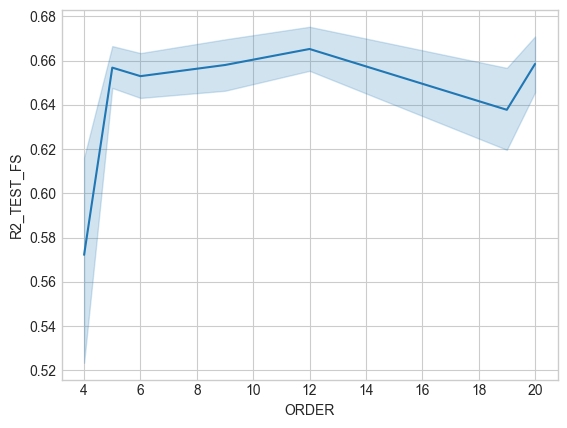

In [32]:
# plt.style.use(['seaborn-v0_8-whitegrid'])
plt.style.use(['seaborn-whitegrid'])
sns.lineplot(data=df2, x='ORDER', y='R2_TEST_FS')


<Axes: xlabel='R2_TEST_FS', ylabel='Density'>

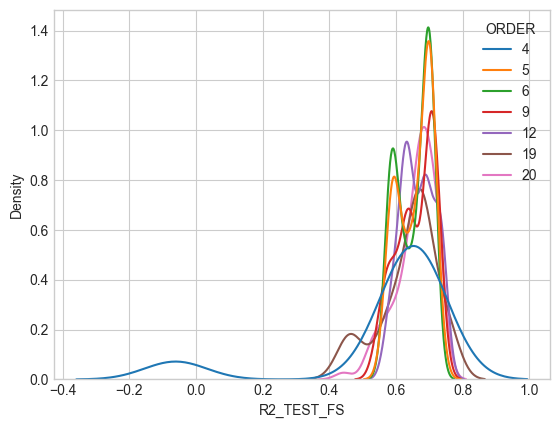

In [33]:
sns.kdeplot(data=df2, x='R2_TEST_FS', hue='ORDER', palette='tab10')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


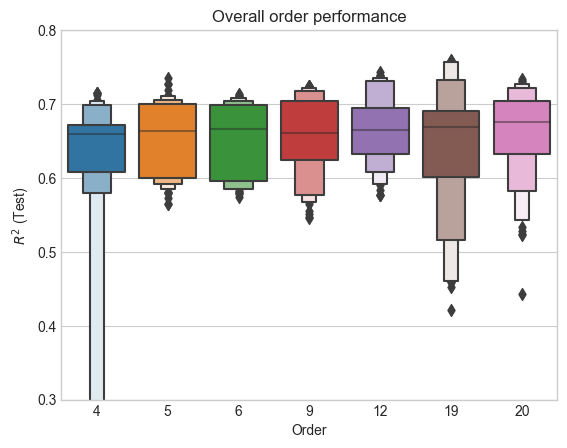

In [36]:
# sns.boxplot(data=df2, x='ORDER', y='R2_TEST_FS',showmeans=False, meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black", "markersize":8},)
ax = sns.boxenplot(data=df2, x='ORDER', y='R2_TEST_FS')
plt.ylim([0.3,.8])
plt.title("Overall order performance")
plt.ylabel('$R^2$ (Test)')
plt.xlabel('Order')



p = os.path.join(os.getcwd(), 'outputs', 'images_decomposition', '2_boxplot_order_R2.eps')
ax.get_figure().savefig(p, format='eps')


Reultados

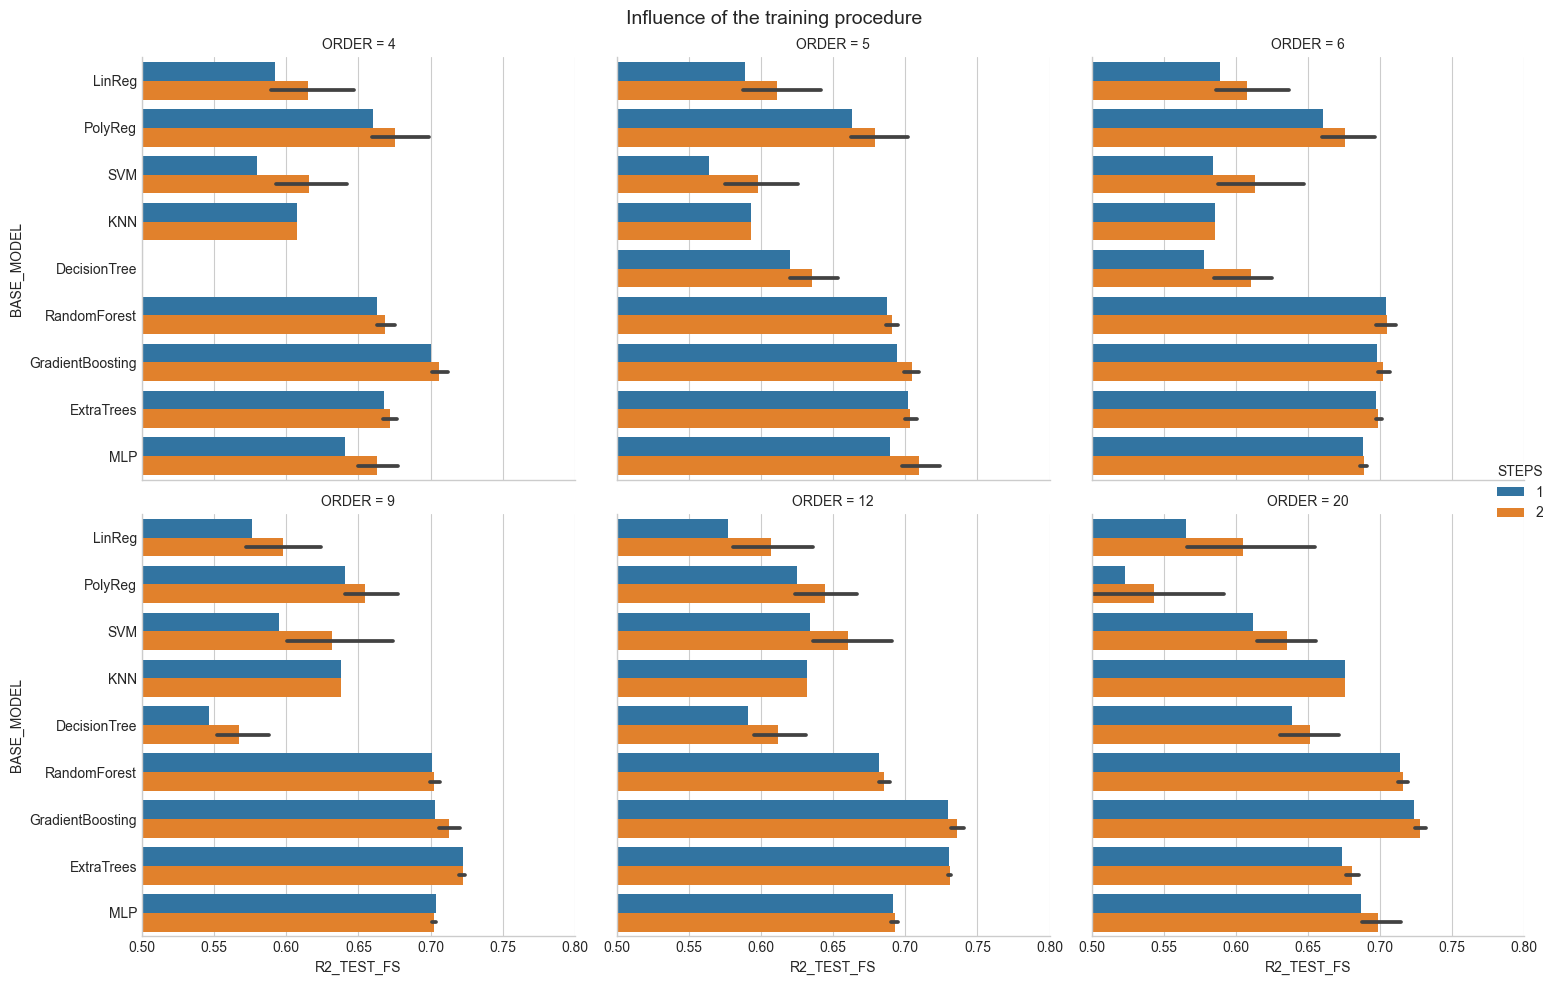

In [54]:
c = sns.catplot(data=df2[~df2['ORDER'].isin([19])], x='R2_TEST_FS', y='BASE_MODEL', hue='STEPS', col='ORDER', col_wrap=3, errorbar=('ci',100), kind='bar')

c.fig.suptitle('Influence of the training procedure', size=14)
c.fig.subplots_adjust(top=.90)
plt.xlim([.50,.80])
plt.tight_layout()

# p = os.path.join(os.getcwd(), 'outputs', 'images_decomposition', '3_catplot_2stepTraining.eps')
# c.fig.savefig(p, format='eps')


In [84]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BASE_MODEL      630 non-null    object 
 1   RESIDUAL_MODEL  630 non-null    object 
 2   ORDER           630 non-null    int64  
 3   R2_TRAIN_OSA    594 non-null    float64
 4   R2_TEST_OSA     594 non-null    float64
 5   R2_TRAIN_FS     594 non-null    float64
 6   R2_TEST_FS      594 non-null    float64
 7   RMSE_TRAIN_OSA  630 non-null    float64
 8   RMSE_TEST_OSA   630 non-null    float64
 9   RMSE_TRAIN_FS   595 non-null    float64
 10  RMSE_TEST_FS    595 non-null    float64
 11  MODEL_OBJ1      630 non-null    object 
 12  MODEL_OBJ2      567 non-null    object 
 13  STEPS           630 non-null    object 
dtypes: float64(8), int64(1), object(5)
memory usage: 69.0+ KB


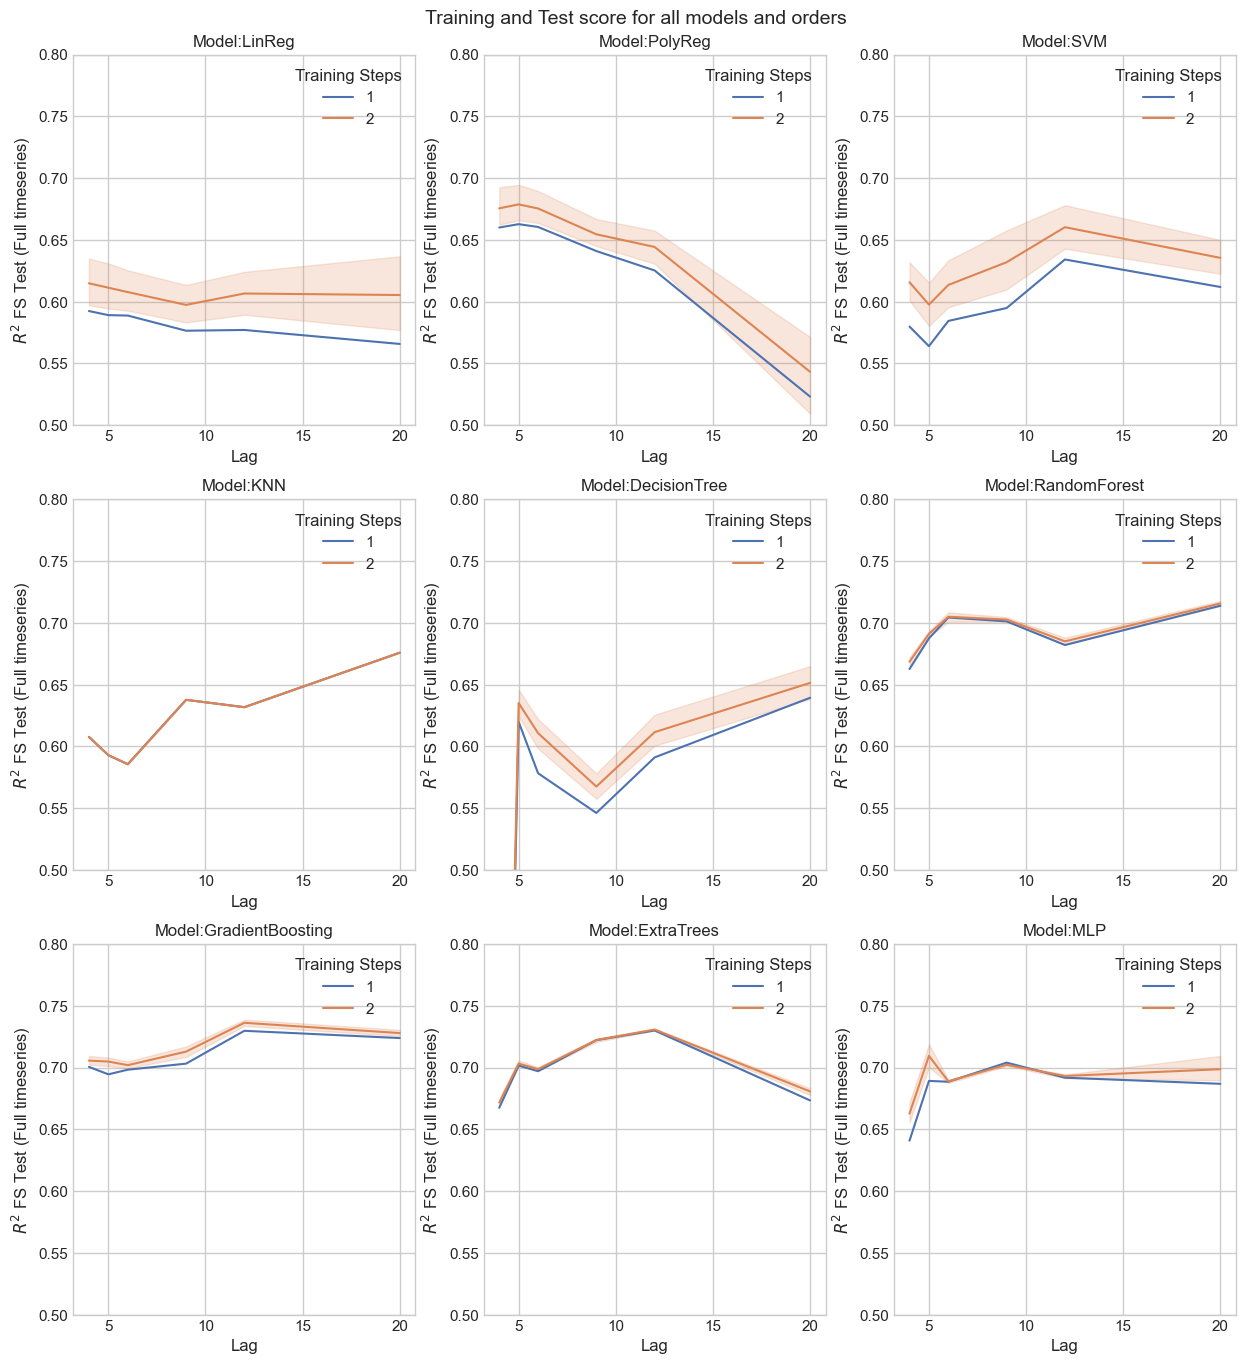

In [81]:
lim=(.5,.8)
fig, ax = plt.subplots(3,3, figsize=(15,15))

ax = ax.flatten()
sns.set(font_scale=1)
plt.style.use(['seaborn-v0_8-whitegrid'])
fig.suptitle('Training and Test score for all models and orders', fontsize=14)
fig.subplots_adjust(top=.95)

for i,m in enumerate(models_ml):
    sns.lineplot(data=df2[df2['BASE_MODEL']==m[0]][~df2['ORDER'].isin([19])], x='ORDER',  y='R2_TEST_FS', hue='STEPS', ax=ax[i])
    ax[i].set_ylim(lim)
    ax[i].set_title(f'Model:{m[0]}')
    ax[i].set_xlabel('Lag')
    ax[i].set_ylabel(f'$R^2$ FS Test (Full timeseries)')
    ax[i].legend(title='Training Steps')
pass;


In [52]:
df2.columns


Index(['BASE_MODEL', 'RESIDUAL_MODEL', 'ORDER', 'R2_TRAIN_OSA', 'R2_TEST_OSA',
       'R2_TRAIN_FS', 'R2_TEST_FS', 'RMSE_TRAIN_OSA', 'RMSE_TEST_OSA',
       'RMSE_TRAIN_FS', 'RMSE_TEST_FS', 'MODEL_OBJ1', 'MODEL_OBJ2', 'STEPS'],
      dtype='object')

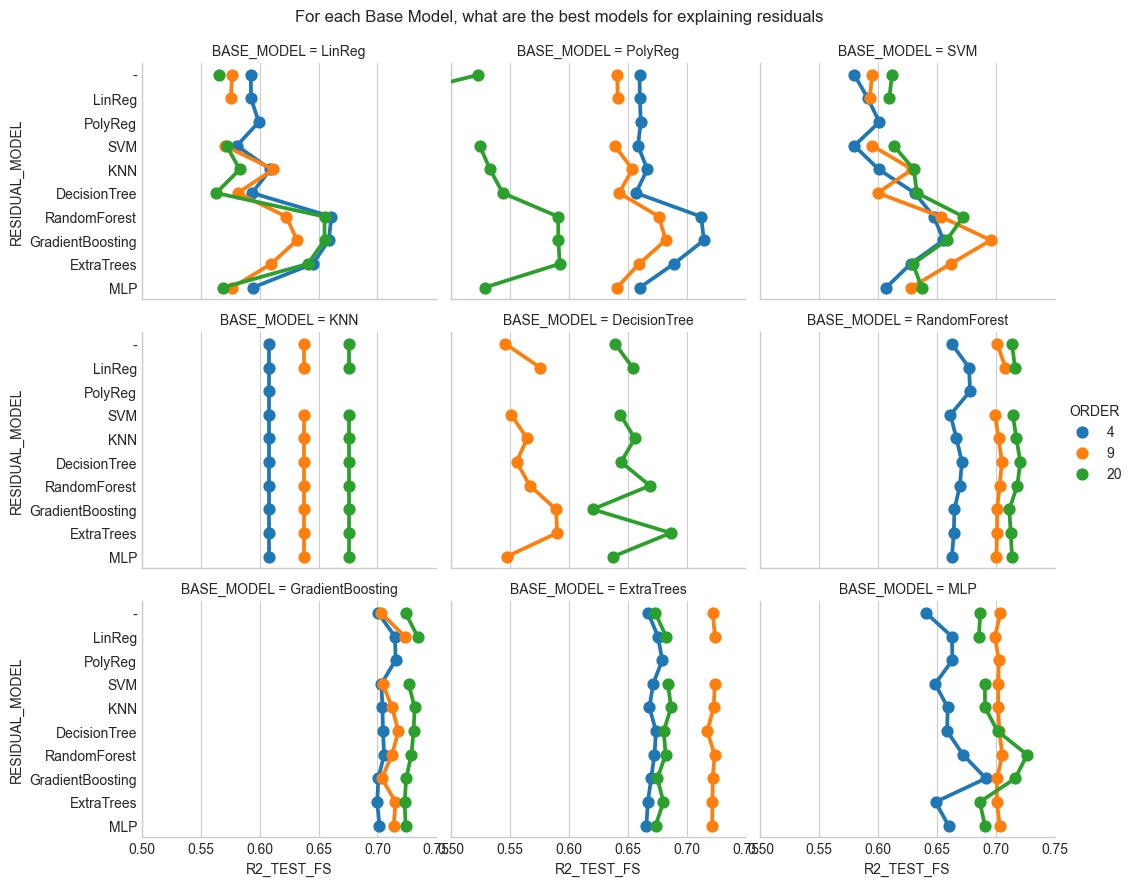

In [53]:
c = sns.catplot(data=df2[df2['ORDER'].isin([4,9,20])], x='R2_TEST_FS', y='RESIDUAL_MODEL', hue='ORDER', col='BASE_MODEL', col_wrap=3, errorbar=('ci',100), kind='point', height=3, aspect=1.2)
plt.xlim([.50,.75])
c.fig.suptitle(f'For each Base Model, what are the best models for explaining residuals')
c.fig.subplots_adjust(top=0.92)


Ranqueamento dos melhores casos

In [41]:
df_rank = df2.sort_values(by='R2_TEST_FS', ascending=False).drop_duplicates(subset=['BASE_MODEL', 'RESIDUAL_MODEL']).reset_index()
df_rank.to_clipboard()
df_rank.head(10)


index        BASE_MODEL    RESIDUAL_MODEL  ORDER  R2_TRAIN_OSA  \
0    428  GradientBoosting  BaggingRegressor     15      0.985539   
1    422  GradientBoosting          RidgeReg     15      0.918423   
2    427  GradientBoosting  GradientBoosting     15      0.945233   
3    421  GradientBoosting            LinReg     15      0.920404   
4    426  GradientBoosting      RandomForest     15      0.941130   
5    424  GradientBoosting               KNN     15      1.000000   
6    420  GradientBoosting                 -     15      0.909939   
7    419      RandomForest           XGBoost     15      0.962960   
8    468          RidgeReg  BaggingRegressor     20      0.974149   
9    425  GradientBoosting               MLP     15      0.908066   

   R2_TEST_OSA  R2_TRAIN_FS  R2_TEST_FS  RMSE_TRAIN_OSA  RMSE_TEST_OSA  \
0     0.915605     0.772523    0.748329        0.031734       0.079437   
1     0.871615     0.760991    0.747291        0.075372       0.097976   
2     0.891041     0.757767    0.745308        0.061757       0.090260   
3     0.877226     0.755966    0.742954        0.074451       0.095811   
4     0.891858     0.753302    0.742477        0.064029       0.089921   
5     0.925518     0.753529    0.742312        0.000001       0.074626   
6     0.865462     0.749039    0.738447        0.079195       0.100296   
7     0.905156     0.767554    0.737168        0.050788       0.084211   
8     0.898102     0.771339    0.736674        0.042430       0.087286   
9     0.864952     0.746195    0.734062        0.080014       0.100486   

   RMSE_TRAIN_FS  RMSE_TEST_FS  \
0       0.125863      0.137176   
1       0.129013      0.137459   
2       0.129881      0.137997   
3       0.130363      0.138633   
4       0.131072      0.138762   
5       0.131012      0.138807   
6       0.132200      0.139844   
7       0.127230      0.140185   
8       0.126190      0.140317   
9       0.132947      0.141011   

                                          MODEL_OBJ1  \
0  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
1  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
2  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
3  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
4  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
5  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
6  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
7  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
8  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
9  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   

                                          MODEL_OBJ2 STEPS  
0  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
1  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
2  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
3  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
4  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
5  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
6                                               None     1  
7  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
8  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
9  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2

Swarm Plots misturando as ordens

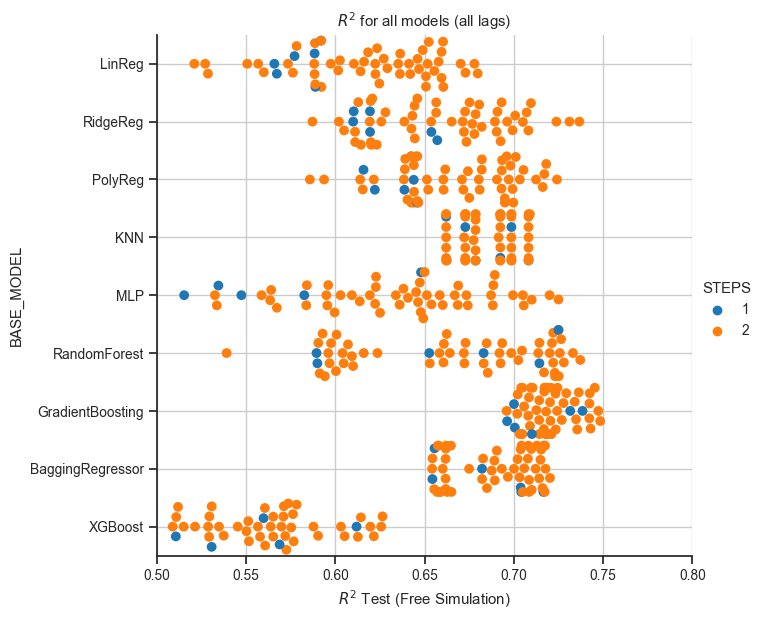

In [34]:

sns.set(font_scale=.9, style='ticks')

catplot = sns.catplot(data=df2, y='BASE_MODEL', x='R2_TEST_FS', hue='STEPS', kind='swarm', height=6, aspect=1.2, s=50, palette='tab10')
plt.xlim((.5,.8))
plt.grid()
plt.xlabel('$R^2$ Test (Free Simulation)')
plt.title('$R^2$ for all models (all lags)')
pass;

# fig = catplot.fig
# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '3_r2_swarm.eps')
# fig.savefig(p, format='eps')


ScatterPlot variando as ordens

In [35]:
df2.columns


Index(['BASE_MODEL', 'RESIDUAL_MODEL', 'ORDER', 'R2_TRAIN_OSA', 'R2_TEST_OSA',
       'R2_TRAIN_FS', 'R2_TEST_FS', 'RMSE_TRAIN_OSA', 'RMSE_TEST_OSA',
       'RMSE_TRAIN_FS', 'RMSE_TEST_FS', 'MODEL_OBJ1', 'MODEL_OBJ2', 'STEPS'],
      dtype='object')

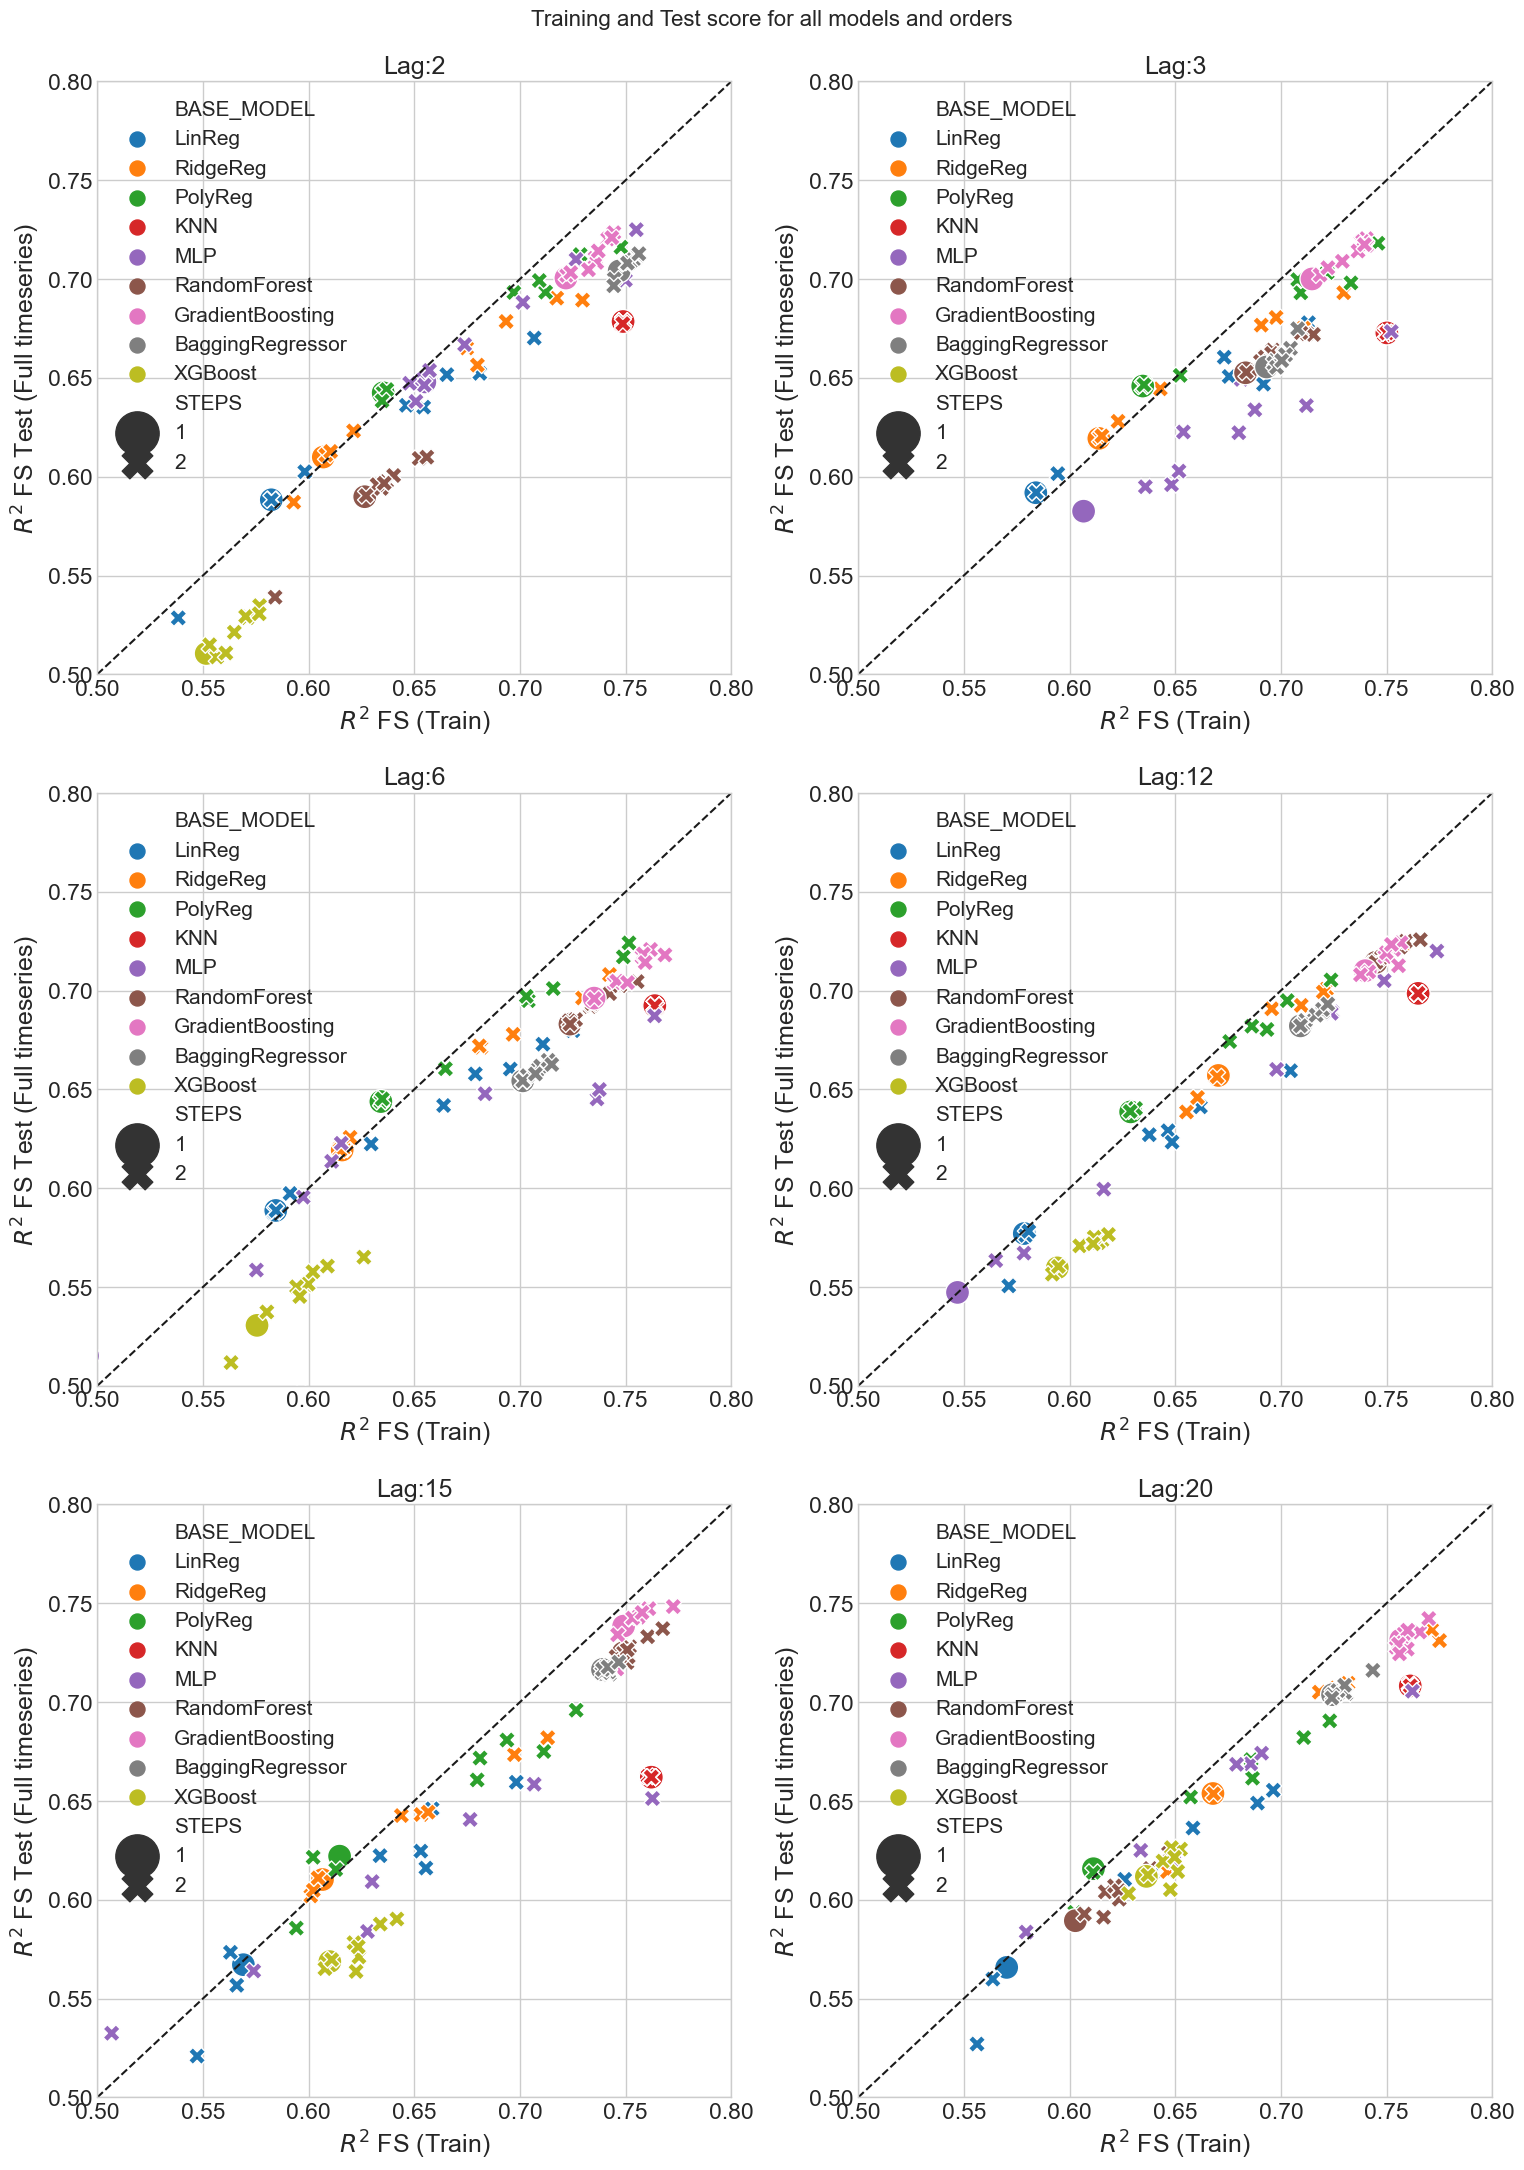

In [411]:
lim=(.5,.8)
fig, ax = plt.subplots(3,2, figsize=(18,24))

ax = ax.flatten()
sns.set(font_scale=1.5)
plt.style.use(['seaborn-v0_8-whitegrid'])
fig.suptitle('Training and Test score for all models and orders', fontsize=16)
fig.subplots_adjust(top=.95)
# plt.tight_layout()

for i,o in enumerate (orders):
# for i,o in enumerate (orders[:-2]):
    sns.scatterplot(data=df2[df2['ORDER']==o], x='R2_TRAIN_FS', y='R2_TEST_FS', hue='BASE_MODEL', ax=ax[i], size='STEPS', style='STEPS', sizes=(150,300), palette='tab10');
    ax[i].plot(lim, lim, '--', c='k')
    ax[i].set_xlim(lim)
    ax[i].set_ylim(lim)
    ax[i].set_title(f'Lag:{o}')
    ax[i].set_xlabel(f'$R^2$ FS (Train)')
    ax[i].set_ylabel(f'$R^2$ FS Test (Full timeseries)')
    ax[i].legend(fontsize=15, markerscale=1.8)

p = os.path.join(os.getcwd(), 'outputs', 'images_decomposition', '4_results_scatter.eps', )
fig.savefig(p, format='eps', bbox_inches='tight')
pass;


Tabela resumo dos resultados

In [136]:
df2.columns


Index(['BASE_MODEL', 'RESIDUAL_MODEL', 'ORDER', 'R2_TRAIN_OSA', 'R2_TEST_OSA',
       'R2_TRAIN_FS', 'R2_TEST_FS', 'RMSE_TRAIN_OSA', 'RMSE_TEST_OSA',
       'RMSE_TRAIN_FS', 'RMSE_TEST_FS', 'MODEL_OBJ1', 'MODEL_OBJ2', 'STEPS'],
      dtype='object')

MELHORES MODELOS

In [243]:
bst = df2.sort_values(['R2_TEST_FS'],ascending=False).drop_duplicates(['BASE_MODEL'])[['BASE_MODEL', 'RESIDUAL_MODEL', 'ORDER', 'R2_TEST_FS', 'RMSE_TEST_FS']]
bst


BASE_MODEL    RESIDUAL_MODEL  ORDER  R2_TEST_FS  RMSE_TEST_FS
428  GradientBoosting  BaggingRegressor     15    0.748329      0.137176
419      RandomForest           XGBoost     15    0.737168      0.140185
468          RidgeReg  BaggingRegressor     20    0.736674      0.140317
48                MLP  BaggingRegressor      2    0.724976      0.143400
208           PolyReg  BaggingRegressor      6    0.724121      0.143622
439  BaggingRegressor           XGBoost     15    0.720175      0.144646
485               KNN               MLP     20    0.708925      0.147525
188            LinReg  BaggingRegressor      6    0.679702      0.154753
538           XGBoost  BaggingRegressor     20    0.626358      0.167144

In [244]:
bst_tup = bst[['BASE_MODEL', 'ORDER']].apply(tuple, axis=1)
bst_tup


428    (GradientBoosting, 15)
419        (RandomForest, 15)
468            (RidgeReg, 20)
48                   (MLP, 2)
208              (PolyReg, 6)
439    (BaggingRegressor, 15)
485                 (KNN, 20)
188               (LinReg, 6)
538             (XGBoost, 20)
dtype: object

MELHORES MODELOS 1 STEP CORRESPONDENTES

In [245]:
corresp = df2[df2[['BASE_MODEL','ORDER']].apply(tuple,1).isin(bst_tup)]
corresp = corresp[corresp['STEPS']=='1'][['BASE_MODEL', 'RESIDUAL_MODEL', 'ORDER', 'R2_TEST_FS', 'RMSE_TEST_FS']]
corresp


BASE_MODEL RESIDUAL_MODEL  ORDER  R2_TEST_FS  RMSE_TEST_FS
40                MLP              -      2    0.647946      0.162243
180            LinReg              -      6    0.588740      0.175356
200           PolyReg              -      6    0.643845      0.163186
410      RandomForest              -     15    0.724934      0.143411
420  GradientBoosting              -     15    0.738447      0.139844
430  BaggingRegressor              -     15    0.716507      0.145591
460          RidgeReg              -     20    0.653752      0.160900
480               KNN              -     20    0.708189      0.147711
530           XGBoost              -     20    0.611815      0.170366

In [284]:
bst2 = bst.merge(corresp, on='BASE_MODEL', how='left', suffixes=('(2step)', '(base)')).drop(['RESIDUAL_MODEL(base)', 'ORDER(base)'], axis=1)
bst2['R2_%'] = 100*(bst2['R2_TEST_FS(2step)']/bst2['R2_TEST_FS(base)']-1).round(decimals=3)
bst2['RMSE_%'] = 100*(1-bst2['RMSE_TEST_FS(2step)']/bst2['RMSE_TEST_FS(base)']).round(decimals=3)
bst2.rename(columns={'RESIDUAL_MODEL(2step)':'RESIDUAL_MODEL', 'ORDER(2step)':'ORDER'}, inplace=True)

# reordenando
bst2 = bst2.iloc[:, [0,1,2,3,5,7,4,6,8]]
bst2.to_clipboard()
bst2


BASE_MODEL    RESIDUAL_MODEL  ORDER  R2_TEST_FS(2step)  \
0  GradientBoosting  BaggingRegressor     15           0.748329   
1      RandomForest           XGBoost     15           0.737168   
2          RidgeReg  BaggingRegressor     20           0.736674   
3               MLP  BaggingRegressor      2           0.724976   
4           PolyReg  BaggingRegressor      6           0.724121   
5  BaggingRegressor           XGBoost     15           0.720175   
6               KNN               MLP     20           0.708925   
7            LinReg  BaggingRegressor      6           0.679702   
8           XGBoost  BaggingRegressor     20           0.626358   

   R2_TEST_FS(base)  R2_%  RMSE_TEST_FS(2step)  RMSE_TEST_FS(base)  RMSE_%  
0          0.738447   1.3             0.137176            0.139844     1.9  
1          0.724934   1.7             0.140185            0.143411     2.2  
2          0.653752  12.7             0.140317            0.160900    12.8  
3          0.647946  11.9             0.143400            0.162243    11.6  
4          0.643845  12.5             0.143622            0.163186    12.0  
5          0.716507   0.5             0.144646            0.145591     0.6  
6          0.708189   0.1             0.147525            0.147711     0.1  
7          0.588740  15.5             0.154753            0.175356    11.7  
8          0.611815   2.4             0.167144            0.170366     1.9

Avaliando os melhores preditores de residuos

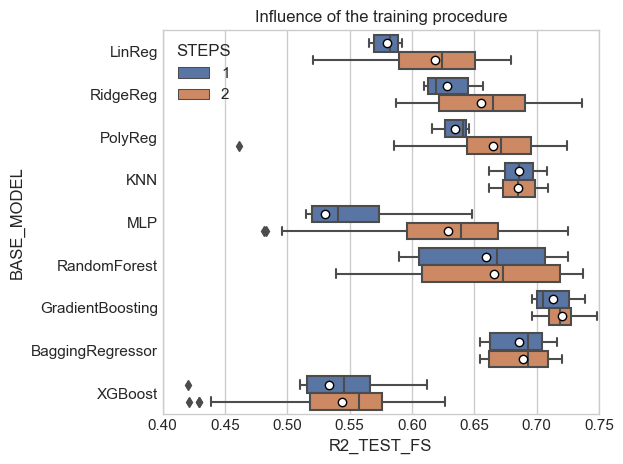

In [392]:
sns.set(font_scale=1)
plt.style.use(['seaborn-v0_8-whitegrid'])

sns.boxplot(data=df2, hue='STEPS', x='R2_TEST_FS', y='BASE_MODEL', showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, width=0.8)
plt.title('Influence of the training procedure')
plt.xlim((.4,.75))
plt.tight_layout()

p = os.path.join(os.getcwd(), 'outputs', 'images_decomposition', '2_boxplot_2step_R2.eps')
plt.savefig(p, format='eps')
pass;


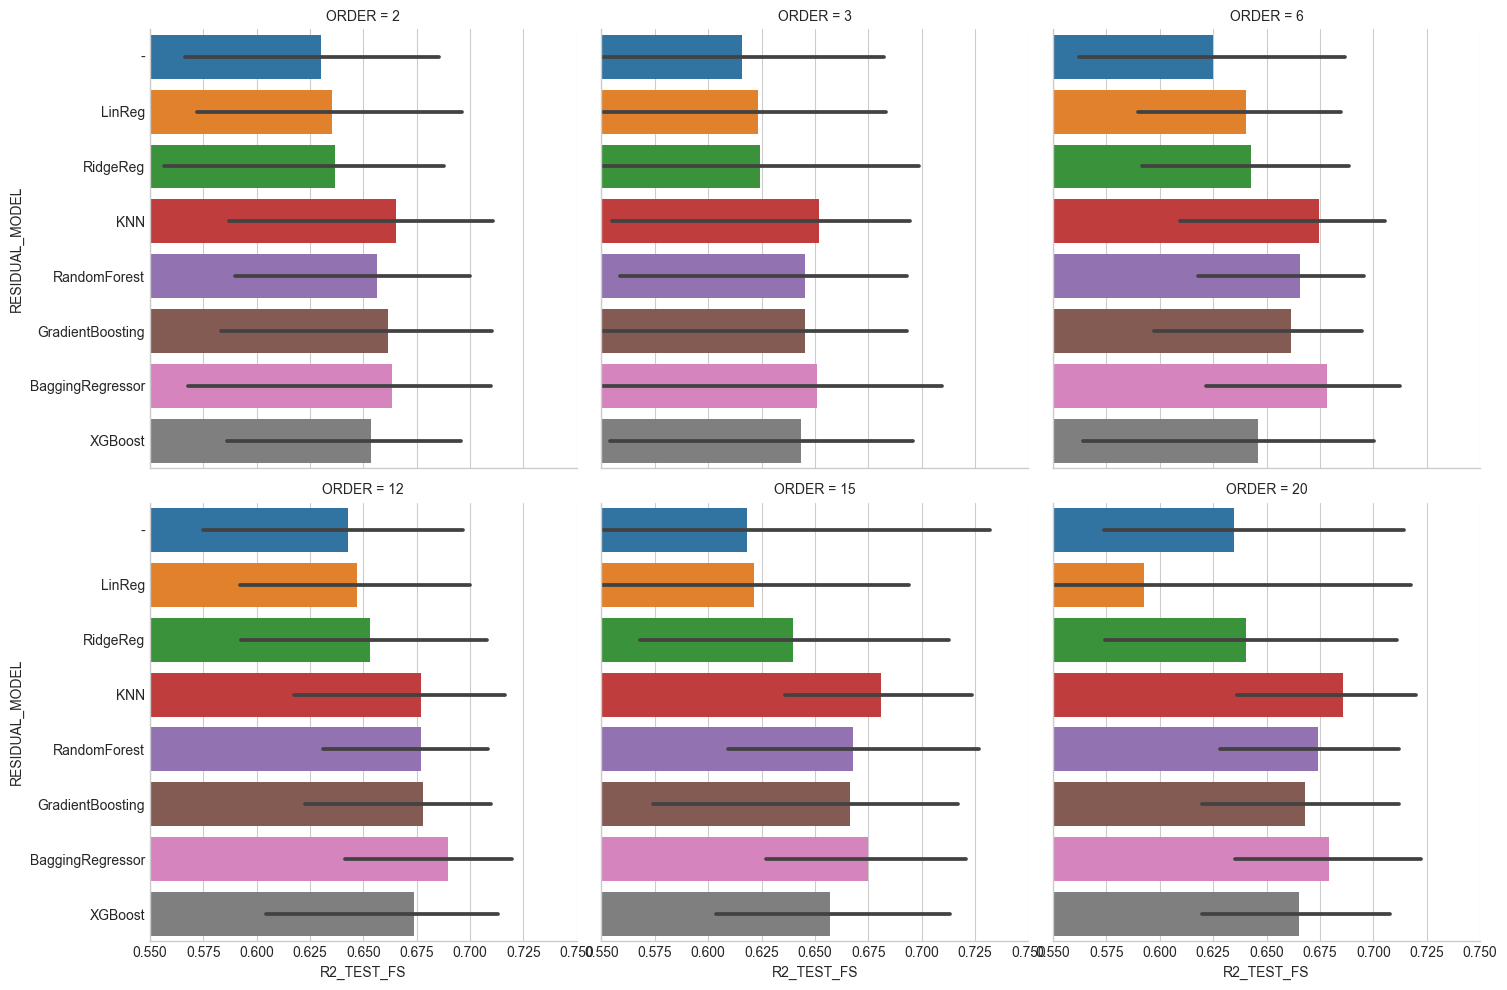

In [143]:
c = sns.catplot(data=df2[~df2.RESIDUAL_MODEL.isin(['MLP', 'PolyReg'])], y='RESIDUAL_MODEL', x='R2_TEST_FS', kind='bar', col_wrap=3, col='ORDER', errorbar=('ci',100),)
plt.xlim((0.55,0.75))

# p = os.path.join(os.getcwd(), 'outputs', 'images_decomposition', '9_best_residual_models.eps')
# c.fig.savefig(p, format='eps')


Predictions

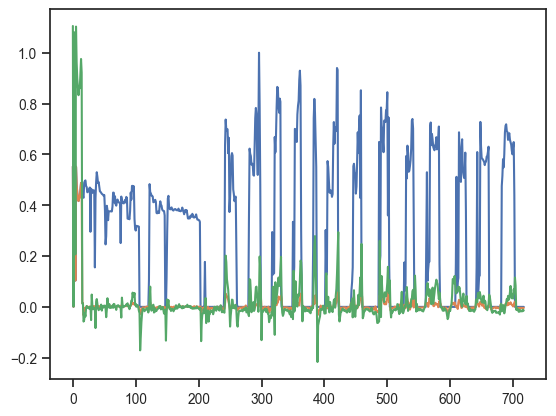

In [37]:
plt.plot(y_te)
best_pred = df_rank.loc[0,'MODEL_OBJ1'].predict(X1_te, y=y_te)
best_pred_r = df_rank.loc[0,'MODEL_OBJ2'].predict(X1_te, y=y_te)
plt.plot(best_pred)
plt.plot(best_pred+best_pred_r)
pass;


Treinando de novo o melhor modelo porque não consegui recuperar o objeto do modelo treinado que salvei no dataset

In [38]:
order = 15
_, sidmodel = models[8]
_, sidmodel_res = models[11]
sidmodel.nX = order
sidmodel.ny = order
sidmodel_res.nX = order
sidmodel_res.ny = order

# train
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel.fit(X=X1_tr, y=y_tr)

# predictions
y_hat_te_osa = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
y_hat_tr_osa = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)
y_hat_te_fs = sidmodel.predict(X1_te, y=y_te)

# ###################################################
# Training Step 2: training on train set residuals
# ###################################################
# residuals
yr_tr = y_tr - y_hat_tr_osa
yr_te = y_te - y_hat_te_osa

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel_res.fit(X=X1_tr, y=yr_tr)

# predictions
yr_hat_te_fs  = sidmodel_res.predict(X1_te, y=yr_te)
# combined (final) predictions
yf_hat_te_fs = y_hat_te_fs + yr_hat_te_fs


In [39]:
r2_score(y_te, y_hat_te_fs), r2_score(y_te, yf_hat_te_fs)


(0.7384473608538591, 0.74832935846365)

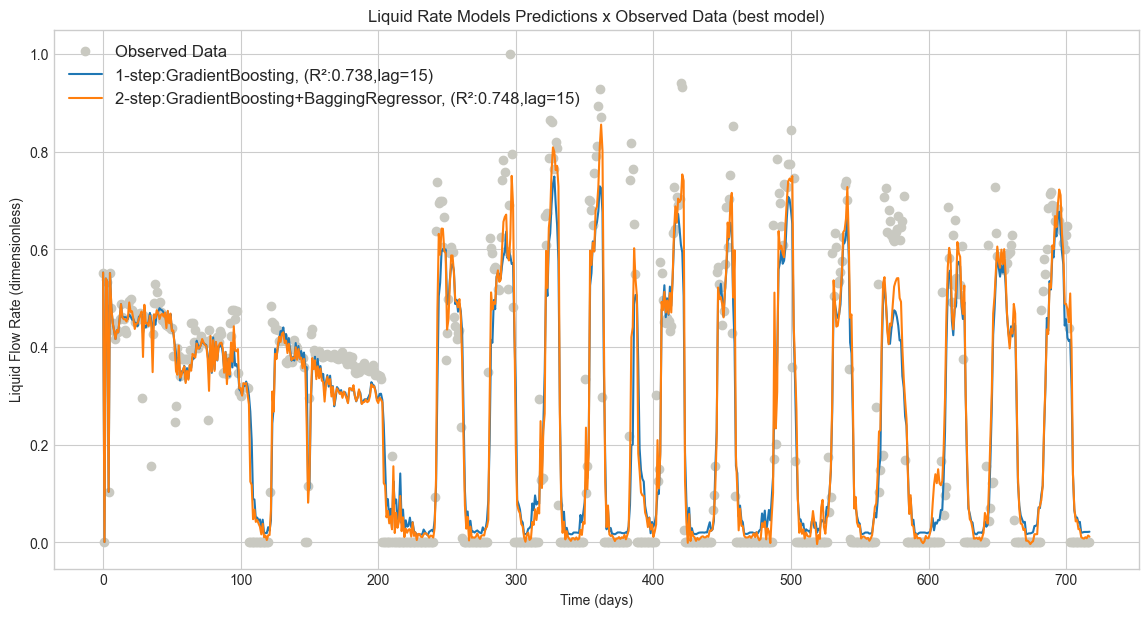

In [42]:
fig = plt.figure(figsize=(14,7))
plt.plot(y_te, 'o', label='Observed Data', c='#c9c9c1')

# plot best modl predictions
plt.plot(y_hat_te_fs, label=f"1-step:{df_rank.loc[6,'BASE_MODEL']}, (R²:{df_rank.loc[6,'R2_TEST_FS']:.3f},lag={df_rank.loc[0,'ORDER']})")
plt.plot(yf_hat_te_fs, label=f"2-step:{df_rank.loc[0,'BASE_MODEL']}+{df_rank.loc[0,'RESIDUAL_MODEL']}, (R²:{df_rank.loc[0,'R2_TEST_FS']:.3f},lag={df_rank.loc[0,'ORDER']})")
plt.legend()

plt.ylabel('Liquid Flow Rate (dimensionless)')
plt.xlabel('Time (days)')
plt.legend(fontsize='12', loc='upper left')
plt.title('Liquid Rate Models Predictions x Observed Data (best model)')

p = os.path.join(os.getcwd(), 'outputs', 'images_decomposition', '5_predictions_best_W1.eps')
fig.savefig(p, format='eps')
pass;


Treinando agora um modelo linear onde o treinamento de residuos fez bastante diferenca

In [52]:
order = 2
_, sidmodel = models[1] # ridge
_, sidmodel_res = models[4] # knn
sidmodel.nX = order
sidmodel.ny = order
sidmodel_res.nX = order
sidmodel_res.ny = order

# train
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel.fit(X=X1_tr, y=y_tr)

# predictions
y_hat_tr_osa = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)
y_hat_te_osa = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
y_hat_te_fs = sidmodel.predict(X1_te, y=y_te)

# ###################################################
# Training Step 2: training on train set residuals
# ###################################################
# residuals
yr_tr = y_tr - y_hat_tr_osa
yr_te = y_te - y_hat_te_osa

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel_res.fit(X=X1_tr, y=yr_tr)

# predictions
yr_hat_te_fs  = sidmodel_res.predict(X1_te, y=yr_te)
# combined (final) predictions
yf_hat_te_fs = y_hat_te_fs + yr_hat_te_fs


In [53]:
r2_score(y_te, y_hat_te_fs), r2_score(y_te, yf_hat_te_fs)


(0.6099286825922325, 0.6893179078699072)

In [55]:
df2[(df2['BASE_MODEL'] == 'RidgeReg') & (df2['ORDER'] == 2)].head(10)


BASE_MODEL    RESIDUAL_MODEL  ORDER  R2_TRAIN_OSA  R2_TEST_OSA  \
10   RidgeReg                 -      2      0.799484     0.787613   
11   RidgeReg            LinReg      2      0.800516     0.789349   
12   RidgeReg          RidgeReg      2      0.800335     0.788466   
13   RidgeReg           PolyReg      2      0.806475     0.791836   
14   RidgeReg               KNN      2      1.000000     0.921584   
15   RidgeReg               MLP      2      0.779095     0.765857   
16   RidgeReg      RandomForest      2      0.885694     0.854344   
17   RidgeReg  GradientBoosting      2      0.897235     0.861919   
18   RidgeReg  BaggingRegressor      2      0.923969     0.880374   
19   RidgeReg           XGBoost      2      0.874253     0.841367   

    R2_TRAIN_FS  R2_TEST_FS  RMSE_TRAIN_OSA  RMSE_TEST_OSA  RMSE_TRAIN_FS  \
10     0.606951    0.609929    1.181688e-01       0.126016       0.165444   
11     0.608205    0.610963    1.178642e-01       0.125500       0.165180   
12     0.610424    0.612776    1.179177e-01       0.125763       0.164711   
13     0.621274    0.623144    1.160904e-01       0.124757       0.162402   
14     0.729583    0.689318    1.990601e-18       0.076571       0.137229   
15     0.592945    0.587119    1.240313e-01       0.132313       0.168366   
16     0.674788    0.665109    8.921985e-02       0.104358       0.150491   
17     0.693446    0.678536    8.459628e-02       0.101608       0.146110   
18     0.717403    0.690336    7.276509e-02       0.094575       0.140285   
19     0.679867    0.656447    9.357874e-02       0.108908       0.149311   

    RMSE_TEST_FS                                         MODEL_OBJ1  \
10      0.170779  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
11      0.170552  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
12      0.170155  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
13      0.167861  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
14      0.152413  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
15      0.175701  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
16      0.158239  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
17      0.155035  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
18      0.152163  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   
19      0.160273  SYSIDRegressor(estimator=RandomizedSearchCV(cv...   

                                           MODEL_OBJ2 STEPS  
10                                               None     1  
11  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
12  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
13  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
14  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
15  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
16  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
17  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
18  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2  
19  SYSIDRegressor(estimator=RandomizedSearchCV(cv...     2

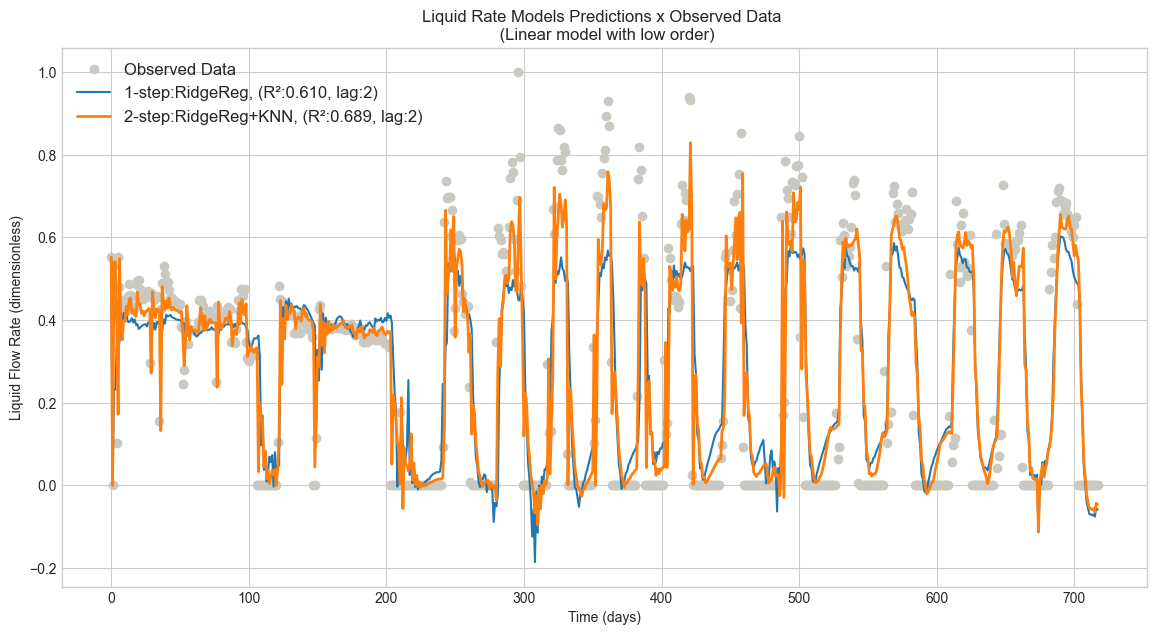

In [57]:
fig = plt.figure(figsize=(14,7))
plt.plot(y_te, 'o', label='Observed Data', c='#c9c9c1')

# plot best modl predictions
plt.plot(y_hat_te_fs, label=f"1-step:{df2.loc[10,'BASE_MODEL']}, (R²:{df2.loc[10,'R2_TEST_FS']:.3f}, lag:{df2.loc[14,'ORDER']})")
plt.plot(yf_hat_te_fs, label=f"2-step:{df2.loc[14,'BASE_MODEL']}+{df2.loc[14,'RESIDUAL_MODEL']}, (R²:{df2.loc[14,'R2_TEST_FS']:.3f}, lag:{df2.loc[14,'ORDER']})", lw=2)
plt.legend()

plt.ylabel('Liquid Flow Rate (dimensionless)')
plt.xlabel('Time (days)')
plt.legend(fontsize='12', loc='upper left')
plt.title('Liquid Rate Models Predictions x Observed Data \n (Linear model with low order)')

p = os.path.join(os.getcwd(), 'outputs', 'images_decomposition', '6_predictions_best_W1Lin.eps')
fig.savefig(p, format='eps')
pass;


#### Estudos dos tempos e parametros (parei por aqui)

parametros dos melhores modelos

In [ ]:
for i,m in enumerate(df_rank['MODEL_OBJ']):
    print (i+1, end=',')
    if m.estimator.cv == 'prefit': #stack
        # print (m.estimator.final_estimator_.cv_results_['params'])
        print (m.estimator.final_estimator_.best_estimator_)
    else: #no stack
        # print (m.estimator.cv_results_['params'])
        print (m.estimator.best_estimator_)


In [ ]:
for i,m in enumerate(df_rank['MODEL_OBJ']):
    # print (i+1, end=',')
    if m.estimator.cv == 'prefit': #stack
        estim_cvr = m.estimator.final_estimator_.cv_results_
    else: #no stack
        estim_cvr = m.estimator.cv_results_
    print (f"{np.mean(estim_cvr['mean_fit_time'])*1000:.0f}")


# plt.plot(best_pred, label=f"{df_rank.loc[0,'MODEL']}, (R²:{df_rank.loc[0,'R2_TEST_FS']:.2f}, lag:{df_rank.loc[0,'ORDER']})")
